In [ ]:
# Neural Network code

### Data cleaning and preprocessing

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from nba_api.stats.endpoints import playercareerstats
import numpy as np
import pandas as pd
from nba_api.stats.endpoints import shotchartdetail
import tensorflow as tf
import tensorflow.keras as keras

pd.set_option('display.max_columns', None)  

seasons = [
    '2016-17', '2017-18', '2018-19',
    '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'
]

def find_player(player_id):
    for season in seasons:
        shots = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=player_id,  
            season_type_all_star='Regular Season',
            context_measure_simple='FGA',
            season_nullable=season
        ).get_data_frames()[0]
        shots['SEASON'] = season
        if 'shots_df' not in locals():
            shots_df = shots
        else:
            shots_df = pd.concat([shots_df, shots], ignore_index=True)
    return shots_df

curry = find_player(201939)
df = curry[['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'LOC_X','LOC_Y', 'SHOT_MADE_FLAG', 'HTM', 'VTM']].copy()
df['Time_remaining'] = df['MINUTES_REMAINING'] * 60 + df['SECONDS_REMAINING']
df['Opponent'] = np.where(df['HTM']  == 'GSW', df['VTM'], df['HTM'])
df['Home'] = np.where(df['HTM'] == 'GSW', 1, 0)
df = df.drop(columns=['MINUTES_REMAINING', 'SECONDS_REMAINING', 'HTM', 'VTM'])
df




,PERIOD,ACTION_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG,Time_remaining,Opponent,Home
0,1,Jump Shot,130,257,0,542,SAS,1
1,1,Step Back Jump shot,189,174,1,486,SAS,1
2,1,Jump Shot,159,229,0,143,SAS,1
3,1,Jump Shot,163,141,0,121,SAS,1
4,2,Jump Shot,-9,267,1,407,SAS,1
...,...,...,...,...,...,...,...,...
8890,4,Step Back Jump shot,129,243,1,19,OKC,0
8891,4,Pullup Jump shot,-4,290,0,0,OKC,0
8892,5,Jump Shot,1,294,1,237,OKC,0
8893,5,Driving Floating Jump Shot,70,142,1,147,OKC,0


Epoch 1/20


c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5125 - loss: 6.4354 - val_accuracy: 0.4986 - val_loss: 0.7383
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5078 - loss: 0.9500 - val_accuracy: 0.5084 - val_loss: 0.6908
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5265 - loss: 0.7746 - val_accuracy: 0.5147 - val_loss: 0.6878
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 0.7161 - val_accuracy: 0.5562 - val_loss: 0.6857
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5438 - loss: 0.7009 - val_accuracy: 0.5576 - val_loss: 0.6867
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.7036 - val_accuracy: 0.5646 - val_loss: 0.6860
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5418 - loss: 0.6943 - val_accuracy: 0.5674 - val_loss: 0.6849
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5417 - loss: 0.6945 - val_accuracy: 0.5660 - val_

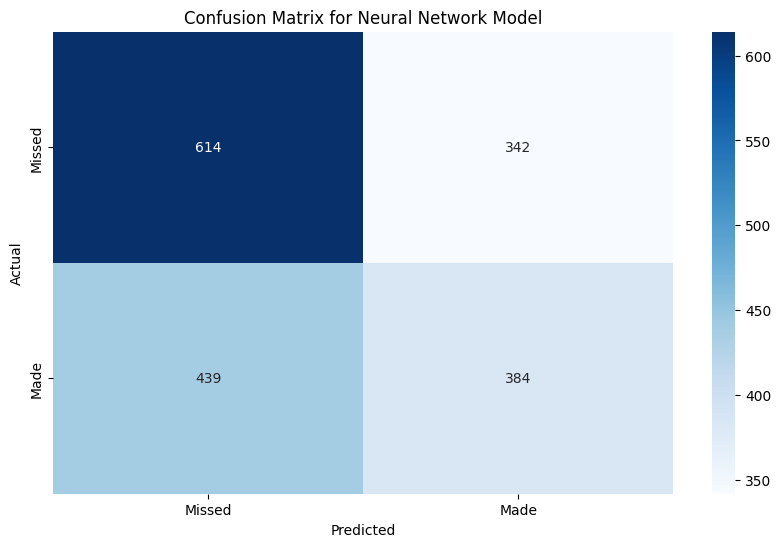

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X = pd.get_dummies(df.drop(columns=['SHOT_MADE_FLAG']), columns=['ACTION_TYPE', 'Opponent'])
X = X.astype('float32')  
y = df['SHOT_MADE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

predictions = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forests

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       956
           1       0.54      0.48      0.51       823

    accuracy                           0.57      1779
   macro avg       0.57      0.57      0.57      1779
weighted avg       0.57      0.57      0.57      1779



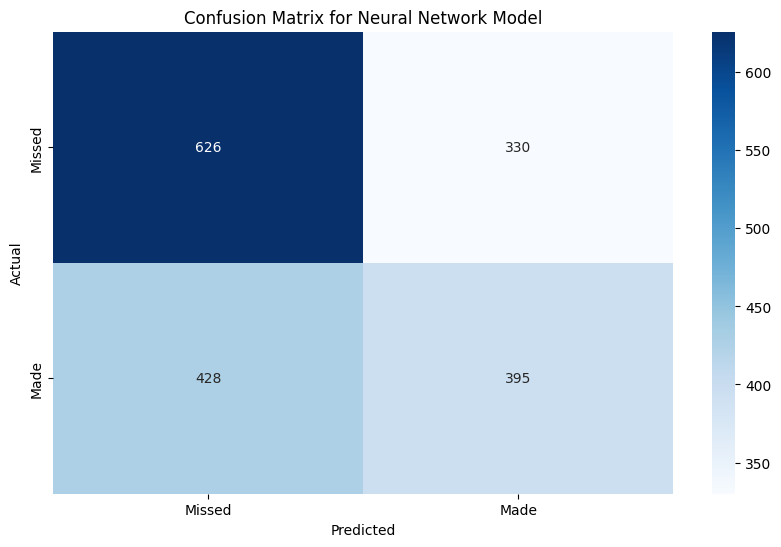

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## XGboost

c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       956
           1       0.53      0.47      0.49       823

    accuracy                           0.56      1779
   macro avg       0.55      0.55      0.55      1779
weighted avg       0.56      0.56      0.56      1779



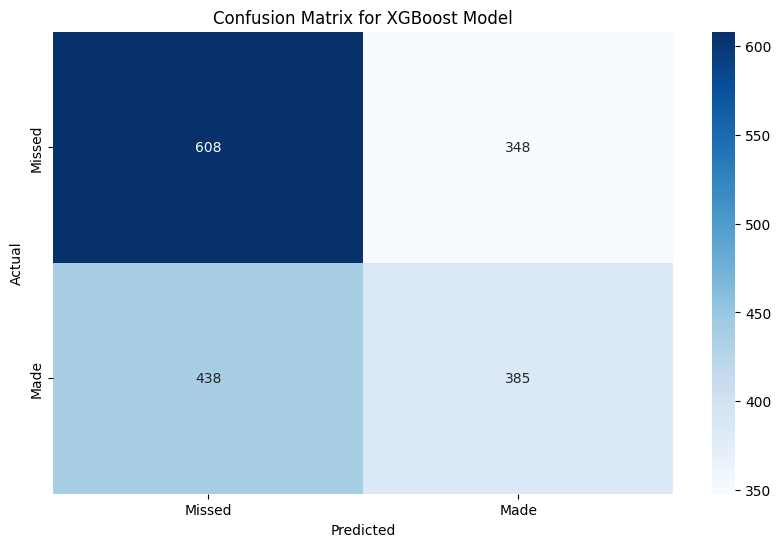

In [40]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Logistic Regression

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       956
           1       0.57      0.42      0.49       823

    accuracy                           0.59      1779
   macro avg       0.58      0.57      0.57      1779
weighted avg       0.58      0.59      0.58      1779



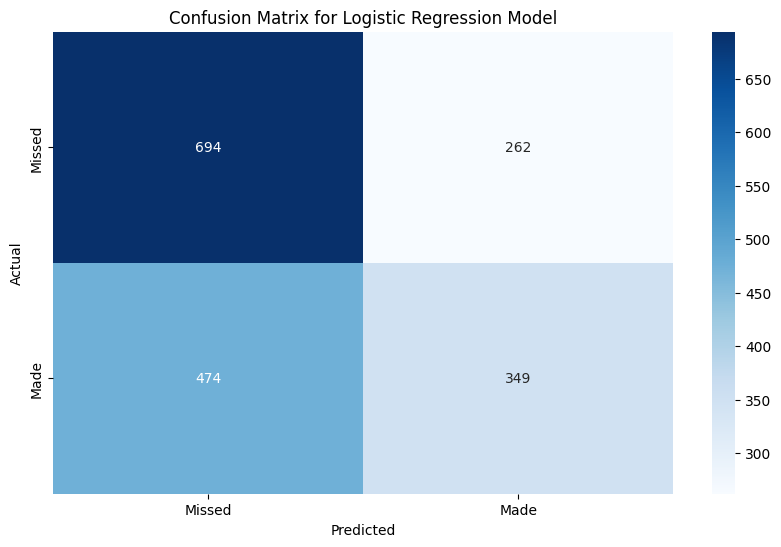

In [42]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter=5000)
lg.fit(X_train, y_train)
lg_predictions = lg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lg_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, lg_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
curry.head(10)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,SEASON
0,Shot Chart Detail,0021600003,19,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,2,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,28,130,257,1,0,20161025,GSW,SAS,2016-17
1,Shot Chart Detail,0021600003,28,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,6,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,25,189,174,1,1,20161025,GSW,SAS,2016-17
2,Shot Chart Detail,0021600003,88,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,23,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,27,159,229,1,0,20161025,GSW,SAS,2016-17
3,Shot Chart Detail,0021600003,91,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,1,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21,163,141,1,0,20161025,GSW,SAS,2016-17
4,Shot Chart Detail,0021600003,184,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,47,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,26,-9,267,1,1,20161025,GSW,SAS,2016-17
5,Shot Chart Detail,0021600003,206,201939,Stephen Curry,1610612744,Golden State Warriors,2,4,58,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,-16,70,1,1,20161025,GSW,SAS,2016-17
6,Shot Chart Detail,0021600003,218,201939,Stephen Curry,1610612744,Golden State Warriors,2,3,34,Made Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-1,7,1,1,20161025,GSW,SAS,2016-17
7,Shot Chart Detail,0021600003,223,201939,Stephen Curry,1610612744,Golden State Warriors,2,3,17,Made Shot,Running Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,27,114,247,1,1,20161025,GSW,SAS,2016-17
8,Shot Chart Detail,0021600003,227,201939,Stephen Curry,1610612744,Golden State Warriors,2,2,55,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,28,130,252,1,0,20161025,GSW,SAS,2016-17
9,Shot Chart Detail,0021600003,289,201939,Stephen Curry,1610612744,Golden State Warriors,3,8,36,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,31,-169,262,1,0,20161025,GSW,SAS,2016-17


Correlation with shot made:
SHOT_MADE_FLAG    1.000000
SHOT_DISTANCE     0.176521
LOC_Y             0.157987
Time_remaining    0.025362
angle             0.020762
Home              0.018410
PERIOD            0.004082
LOC_X             0.003193
dtype: float64


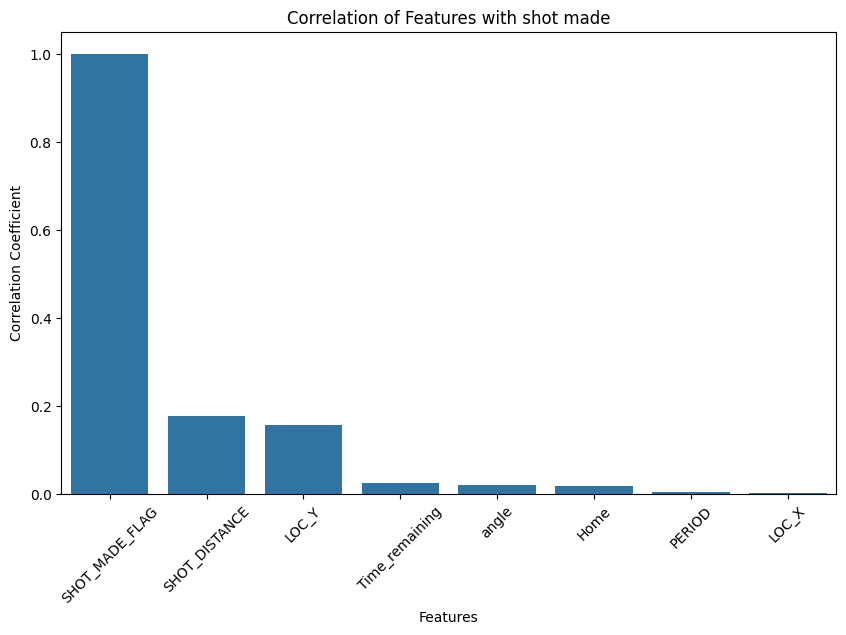

In [95]:

curr = curry[['PERIOD', 'MINUTES_REMAINING', 'ACTION_TYPE', 'SHOT_ZONE_AREA',
       'SECONDS_REMAINING', 'SHOT_ZONE_BASIC', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'HTM', 'VTM', 'SHOT_MADE_FLAG']].copy()
curr['Time_remaining'] = curr['MINUTES_REMAINING'] * 60 + curr['SECONDS_REMAINING']
curr['Home'] = np.where(curr['HTM'] == 'GSW', 1, 0)
curr['angle'] = np.arctan2(curr['LOC_Y'], curr['LOC_X']) * (180 / np.pi)
curr = curr.drop(columns=['MINUTES_REMAINING', 'SECONDS_REMAINING', 'HTM', 'VTM'])

numeric_features = curr.select_dtypes(include=[np.number]).columns
X = curr.drop(columns=['SHOT_MADE_FLAG'])
y = curr['SHOT_MADE_FLAG']

corr = curr[numeric_features].corrwith(y).abs().sort_values(ascending=False)
print("Correlation with shot made:")
print(corr)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr.index, y=corr.values)
plt.title('Correlation of Features with shot made')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

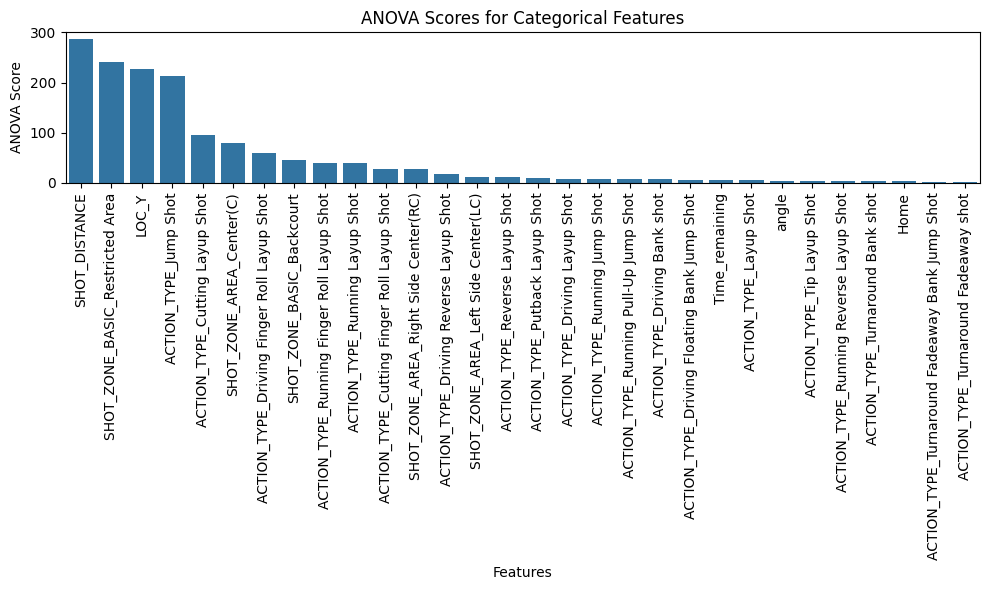

In [96]:
from sklearn.feature_selection import SelectKBest, f_classif

X_encoded = pd.get_dummies(X, drop_first=True)
anova = SelectKBest(score_func=f_classif, k='all')
anova.fit(X_encoded, y)

anova_scores = pd.DataFrame({
    'Feature': X_encoded.columns,
    'ANOVA Score': anova.scores_
}).sort_values(by='ANOVA Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='ANOVA Score', data=anova_scores.head(30))
plt.title('ANOVA Scores for Categorical Features')
plt.ylabel('ANOVA Score')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Epoch 1/20


c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5020 - loss: 7.3579 - val_accuracy: 0.4909 - val_loss: 0.7425
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5146 - loss: 1.0156 - val_accuracy: 0.5126 - val_loss: 0.6845
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5023 - loss: 0.7438 - val_accuracy: 0.5133 - val_loss: 0.6867
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5296 - loss: 0.7141 - val_accuracy: 0.5393 - val_loss: 0.6871
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5282 - loss: 0.7041 - val_accuracy: 0.5183 - val_loss: 0.6860
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5400 - loss: 0.7015 - val_accuracy: 0.5218 - val_loss: 0.6878
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5375 - loss: 0.6887 - val_accuracy: 0.5218 - val_loss: 0.6869
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5196 - loss: 0.6960 - val_accuracy: 0.5204 - val_

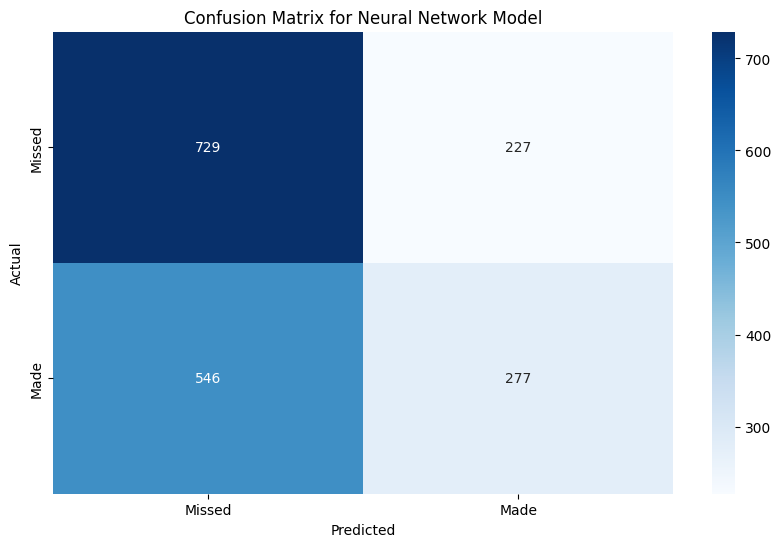

In [97]:
cols = anova_scores['Feature'].head(30).tolist()
X = X_encoded[cols]
X = X.astype('float32')  
y = df['SHOT_MADE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

predictions = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [84]:
print(y.value_counts(normalize=True))

SHOT_MADE_FLAG
0    0.53131
1    0.46869
Name: proportion, dtype: float64


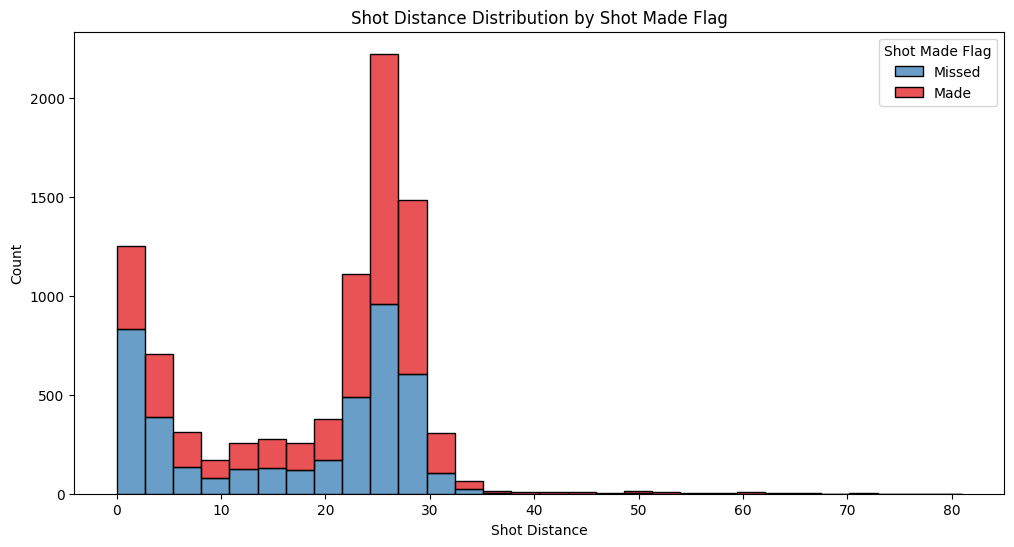

In [98]:
plt.figure(figsize=(12, 6))
sns.histplot(data=curr, x='SHOT_DISTANCE', hue='SHOT_MADE_FLAG', bins=30, multiple='stack', palette='Set1')
plt.title('Shot Distance Distribution by Shot Made Flag')
plt.xlabel('Shot Distance')
plt.ylabel('Count')
plt.legend(title='Shot Made Flag', loc='upper right', labels=['Missed', 'Made'])
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.57      0.76      0.65       956
           1       0.55      0.34      0.42       823

    accuracy                           0.57      1779
   macro avg       0.56      0.55      0.54      1779
weighted avg       0.56      0.57      0.54      1779

AUC-ROC: 0.5681047499453473


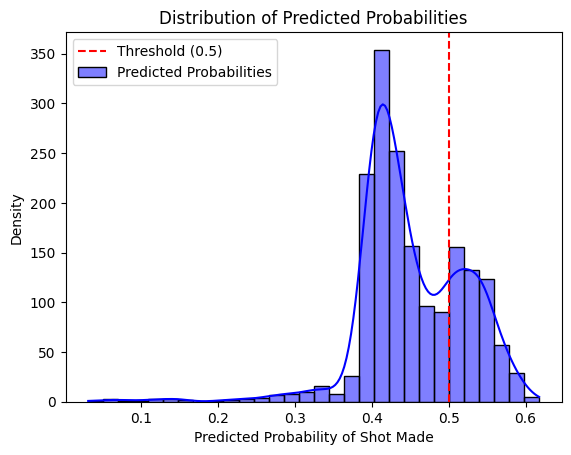

In [100]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_probs = model.predict(X_test).flatten()
y_pred_classes = (y_pred_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred_classes))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_probs))
plt.Figure(figsize=(10, 6))
sns.histplot(y_pred_probs, bins=30, kde=True, color='blue', label='Predicted Probabilities')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Shot Made')
plt.ylabel('Density')
plt.legend()
plt.show()


Epoch 1/20


c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5151 - loss: 10.4470 - val_accuracy: 0.5281 - val_loss: 0.7571
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5074 - loss: 1.6022 - val_accuracy: 0.5513 - val_loss: 0.6882
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5313 - loss: 0.8629 - val_accuracy: 0.5197 - val_loss: 0.6889
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5473 - loss: 0.7417 - val_accuracy: 0.5569 - val_loss: 0.6879
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5193 - loss: 0.7278 - val_accuracy: 0.5197 - val_loss: 0.6871
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5239 - loss: 0.7051 - val_accuracy: 0.5344 - val_loss: 0.6862
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5315 - loss: 0.7182 - val_accuracy: 0.5576 - val_loss: 0.6864
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5403 - loss: 0.6971 - val_accuracy: 0.5632 - val

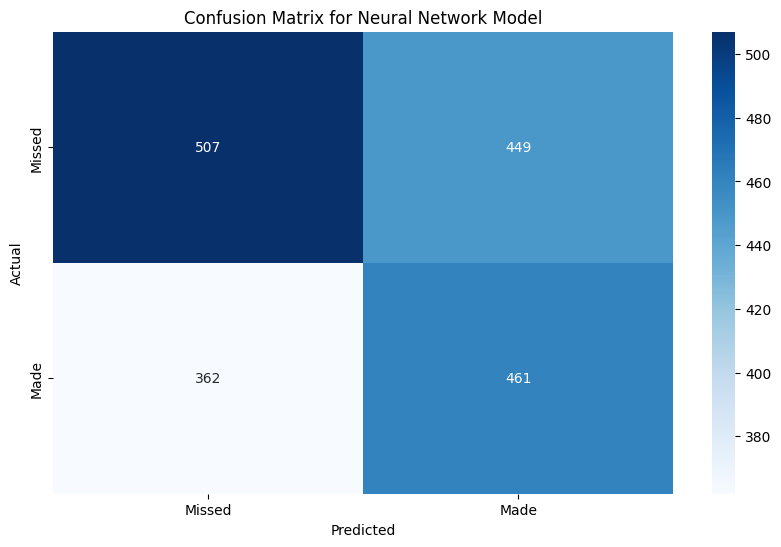

In [104]:
cols = anova_scores['Feature'].head(30).tolist()
X = X_encoded[cols]
X = X.astype('float32')  
y = df['SHOT_MADE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

y_pred_probs = model.predict(X_test).flatten()
y_pred_classes = (y_pred_probs > 0.48).astype(int)

print(classification_report(y_test, y_pred_classes))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()